## Problem Statement 
Every business in the entertainment sector must be able to figure out consumer mood from movie reviews. Through sentiment analysis of movie reviews, the business can learn more about preferences, consumer happiness, and possible areas for growth. Making decisions based on data for consumer engagement, content production, and marketing tactics might benefit from this.


Sentiment analysis gives the business a chance to quickly respond to client feedback, identify trends, and evaluate the public's views. Negative sentiment can point out areas that want improvement, while positive emotion can be used to push activities.

The dataset provided contains movie reviews, along with sentiment classifications (0 for negative and 1 for positive). Data can be gathered for a practical application from social media, business databases, or from online review sites.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import random
from sklearn.metrics import classification_report
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import accuracy
from nltk.classify import NaiveBayesClassifier
from nltk.classify.scikitlearn import SklearnClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

## Data Preprocessing
In data preprocesing we will clean and transform the data to ensure that it is best possible shape for extracting meaningful insights and building robust machine learning models. Here are the main steps for our movies review textual data in the context of NLP. 

In [3]:
df = pd.read_csv('/Users/prerna/Downloads/movie.csv',encoding='unicode_escape')

In [4]:
df.info

<bound method DataFrame.info of                                                  ï»¿text  label
0      I grew up (b. 1965) watching and loving the Th...      0
1      When I put this movie in my DVD player, and sa...      0
2      Why do people who do not know what a particula...      0
3      Even though I have great interest in Biblical ...      0
4      Im a die hard Dads Army fan and nothing will e...      1
...                                                  ...    ...
39995  "Western Union" is something of a forgotten cl...      1
39996  This movie is an incredible piece of work. It ...      1
39997  My wife and I watched this movie because we pl...      0
39998  When I first watched Flatliners, I was amazed....      1
39999  Why would this film be so good, but only gross...      1

[40000 rows x 2 columns]>

The info() method's goal is to give a brief description of the DataFrame. This comprises the amount of RAM used, the data types in each column, and the number of non-null entries.
Knowing the dataset's basic statistics and structure can help you find any missing numbers and make sure the data is formatted as it should be.

In [5]:
df.shape

(40000, 2)

In [52]:
df.head(10)

,ï»¿text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1


In [7]:
df.isna().sum()

ï»¿text    0
label      0
dtype: int64

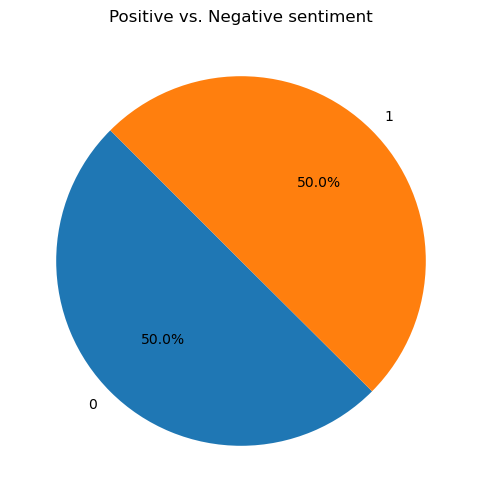

In [8]:
sentiments = df['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(
  sentiments,
  labels=sentiments.index,
  autopct='%1.1f%%',
  startangle=135
  )
plt.title('Positive vs. Negative sentiment')
plt.show()

In [9]:
positive_reviews = df[df['label'] == 1]
negative_reviews = df[df['label'] == 0]

In [10]:
print('Number of positive sentiments:', sentiments[1])
print('Number of negative sentiments: ', sentiments[0])

Number of positive sentiments: 19981
Number of negative sentiments:  20019


In [11]:
sample_positive = positive_reviews.sample(n=10000, random_state=42)
sample_negative = negative_reviews.sample(n=10000, random_state=42)

In [12]:
reviews = pd.concat([sample_positive, sample_negative])
reviews = reviews.sample(frac=1, random_state=42).reset_index(drop=True)

In this we balanced as well as shuffled the data. By balancing the dataset will ensures equal representation of both classes, which will helps in training robust model. Shuffling the data will also ensures that the model is not trained on any particular order, reducing the risk of learning spurious patterns.

In [13]:
reviews.shape

(20000, 2)

In [19]:
reviews.columns = ["text", "label"]

In [20]:
reviews['label'].value_counts()

label
0    10000
1    10000
Name: count, dtype: int64

## Feature Extraction 
We will Convert text data into numerical features using techniques. This will use the collected attributes to train machine learning models (Naive Bayes and SVM). Next, we'll assess the models' performance using metrics like F1-score, accuracy, precision, and recall. Here, we'll use processes to prepare text input for natural language processing (NLP) activities, particularly sentiment analysis.

In [21]:
print(reviews['text'][123])

I really enjoyed this -- I'm a big fan of movies that mess with your mind and leave you with a lot of questions and ideas to debate, and this was a stellar example. But then, Terry Gilliam is always good at that (well, almost always. Let's just forget about Jabberwocky and The Brothers Grimm, shall we?).<br /><br />I particularly liked the way it handled the time travel theme and the avoidance of paradoxes -- the way events in the past and future intertwined and fed into each other.<br /><br />It was also really well done aesthetically -- the art direction was really great, and I wish I'd been able to see it on the big screen. The future scenes had a similar feel to Brazil in a lot of ways, and even the present scenes were often really visually compelling.<br /><br />But perhaps the most striking thing about it was that it featured two actors I normally don't much like, Bruce Willis and Brad Pitt, and they both delivered amazing performances here. Pitt especially -- I'd seen one or two

In [22]:
lemmatizer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

pattern_html = r'<.*?>'

def preprocess_text(text):

  text = re.sub(pattern_html, '', text)

  tokens = word_tokenize(text.lower())

  tokens_filtered = [token for token in tokens if token not in stopwords]

  tokens_filtered = [token for token in tokens_filtered if token not in string.punctuation]

  tokens_filtered = [token for token in tokens_filtered if token.isalpha()]

  tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_filtered]

  preprocessed_text = ' '.join(tokens_lemmatized)

  return preprocessed_text

This Will remove the HTML tags, changing the text's case, tokenizing, filtering out stopwords, punctuation, and non-alphabetic characters, and lemmatizing the tokens, this function cleans and standardises the text, leaving behind a preprocessed text string that can be used as an input for a machine learning model or for additional analysis.

In [23]:
reviews['text'] = reviews['text'].apply(preprocess_text)

In [24]:
documents = [(list(word_tokenize(review)), label) for review, label in zip(reviews['text'], reviews['label'])]
random.shuffle(documents)

In [25]:
def document_unigram_features(document):
    unigrams = {}
    for token in document:
        if token in unigrams:
            unigrams[token] += 1
        else:
            unigrams[token] = 1
    return unigrams

In [26]:
features_uni = [(document_unigram_features(d), c) for (d, c) in documents]

In [27]:
def document_bigram_features(document):
    bigrams = {}
    bigram_finder = BigramCollocationFinder.from_words(document)
    for bigram, freq in bigram_finder.ngram_fd.items():
      bigrams[bigram] = freq
    return bigrams

In [28]:
features_bi = [(document_bigram_features(d), c) for (d, c) in documents]

In [33]:
uni_test_true = [label for (features, label) in test_set_uni]
bi_test_true = [label for (features, label) in test_set_bi]

In [34]:
train_set_uni, test_set_uni = train_test_split(features_uni, test_size=0.2, random_state=123, shuffle=True)
train_set_bi, test_set_bi = train_test_split(features_bi, test_size=0.2, random_state=123, shuffle=True)

## Naive bayes using unigrams

In [35]:
nb_uni = NaiveBayesClassifier.train(train_set_uni)
nb_uni_pred = [nb_uni.classify(features) for (features, label) in test_set_uni]

In [36]:
print(round(accuracy(uni_test_true, nb_uni_pred), 4))

0.8462


In [48]:
print(classification_report(uni_test_true, nb_uni_pred))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      2003
           1       0.82      0.88      0.85      1997

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



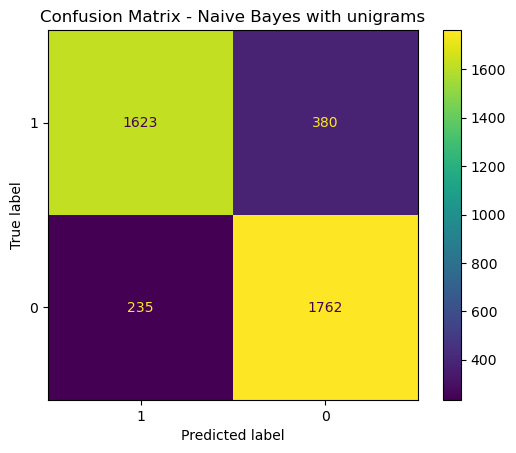

In [37]:
ConfusionMatrixDisplay.from_predictions(
    uni_test_true,
    nb_uni_pred,
    display_labels=[1, 0]
    )
plt.title('Confusion Matrix - Naive Bayes with unigrams')
plt.show()

Naive Bayes Using Unigrams: This was the highest recall for class 1 (0.88), indicating that it is very good at identifying positive sentiments but less balanced than the SVM with unigrams. Overall, we achieved an accuracy of 0.8462, which is slightly behind the SVM with unigrams.

## Naive Bayes Using Bigrams

In [38]:
nb_bi = NaiveBayesClassifier.train(train_set_bi)
nb_bi_pred = [nb_bi.classify(features) for (features, label) in test_set_bi]

In [39]:
print(round(accuracy(bi_test_true, nb_bi_pred), 4))

0.852


In [49]:
print(classification_report(bi_test_true, nb_bi_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2003
           1       0.85      0.85      0.85      1997

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



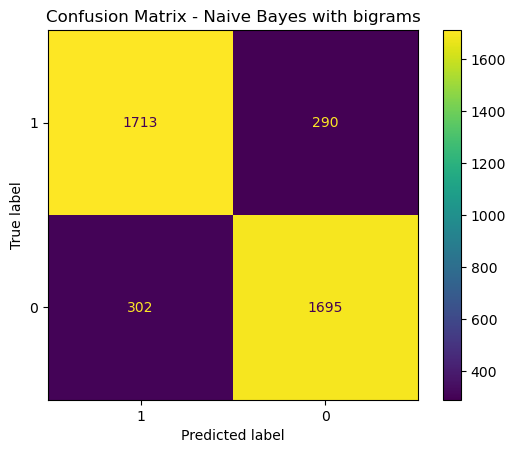

In [40]:
ConfusionMatrixDisplay.from_predictions(
    bi_test_true,
    nb_bi_pred,
    display_labels=[1, 0]
    )
plt.title('Confusion Matrix - Naive Bayes with bigrams')
plt.show()

Naive Bayes Using Bigrams: This model is marginally better than the SVM using unigrams in terms of recall for class 0 (0.86), with an accuracy of 0.85. Its total accuracy was slightly less accurate, yet. This implies that bigrams—pairs of words—can be useful, even though they didn't outperform unigrams in this instance.

## SVM Using Unigrams 

In [41]:
svc_uni = SklearnClassifier(LinearSVC(max_iter=10000)).train(train_set_uni)
svc_uni_pred = [svc_uni.classify(features) for (features, label) in test_set_uni]

In [42]:
print(round(accuracy(uni_test_true, svc_uni_pred), 4))

0.8532


In [50]:
print(classification_report(uni_test_true, svc_uni_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2003
           1       0.85      0.85      0.85      1997

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



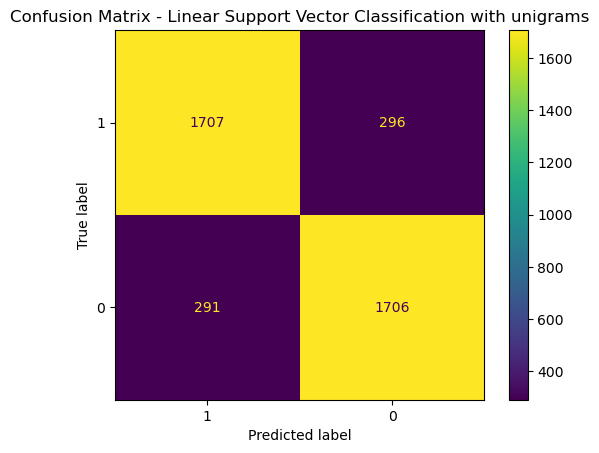

In [53]:
ConfusionMatrixDisplay.from_predictions(
    uni_test_true,
    svc_uni_pred,
    display_labels=[1, 0]
    )
plt.title('Confusion Matrix - Linear Support Vector Classification with unigrams')
plt.show()

SVM Using Unigrams: This has balanced precision, recall, and F1-scores for both classes (0 and 1) and has attained the best accuracy of 0.8532. This suggests that the model uses single words as features and consistently does a good job of distinguishing both positive and negative thoughts.

## SVM Using Bigrams 

In [44]:
svc_bi = SklearnClassifier(LinearSVC(max_iter=10000)).train(train_set_bi)
svc_bi_pred = [svc_bi.classify(features) for (features, label) in test_set_bi]

In [45]:
print(round(accuracy(bi_test_true, svc_bi_pred), 4))

0.841


In [51]:
print(classification_report(bi_test_true, svc_bi_pred))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84      2003
           1       0.82      0.87      0.84      1997

    accuracy                           0.84      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000



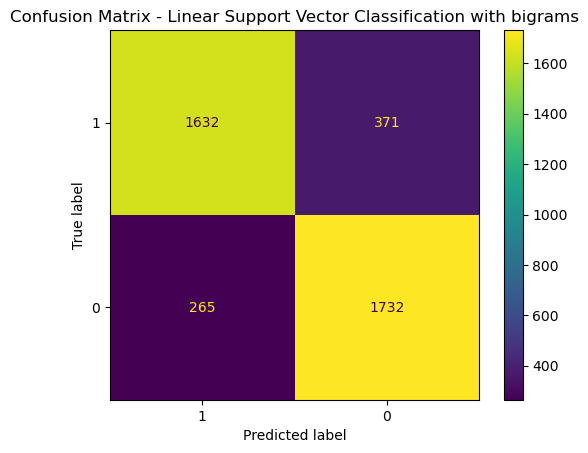

In [46]:
ConfusionMatrixDisplay.from_predictions(
    bi_test_true,
    svc_bi_pred,
    display_labels=[1, 0]
    )
plt.title('Confusion Matrix - Linear Support Vector Classification with bigrams')
plt.show()

Bigrams SVM: This model's accuracy of 0.841 was less than that of its unigram equivalent. Its precision for class 0 was good (0.86), while its recall for class 0 and precision for class 1 were inferior. This suggests that for this dataset, employing unigrams may be more beneficial than utilising bigrams with SVM.

# Model Performance Comparison

| Model                       | Accuracy | Precision 0 | Precision 1 | Recall 0 | Recall 1 | F1-Score 0 | F1-Score 1 |
|-----------------------------|----------|-------------|-------------|----------|----------|------------|------------|
| SVM With Unigrams           | 0.8532   | 0.85        | 0.85        | 0.85     | 0.85     | 0.85       | 0.85       |
| Naive Bayes With Bigrams    | 0.85     | 0.85        | 0.85        | 0.86     | 0.85     | 0.85       | 0.85       |
| SVM With Bigrams            | 0.841    | 0.86        | 0.82        | 0.81     | 0.87     | 0.84       | 0.84       |
| Naive Bayes With Unigrams   | 0.8462   | 0.87        | 0.82        | 0.81     | 0.88     | 0.84       | 0.85       |


SVM with Unigrams has the best accuracy of any model, with a 0.8532 accuracy. For all classes, our model performed equally well in terms of precision, recall, and F1-scores. As a result, for sentiment analysis on this movie reviews dataset, the SVM with unigrams is best. This method yields consistent and dependable results while effectively capturing the sentiment from individual words.

The significance of feature extraction and model selection strategies in NLP tasks is emphasised by this finding. For this particular objective, simplicity with unigrams combined with a strong algorithm like SVM appears to be the most effective strategy, even though more complex features like bigrams can offer minor advantages in certain areas.